First of all, set the 'CODE_DIR' to where the model code are saved. This will change current working directory and print for checking. Afterwards, we import all required modules.

In [1]:
# locate the root folder
CODE_DIR = '../'

import os
os.chdir(f'{CODE_DIR}')

notebook_path = os.getcwd()
print('Current working directory is:', '\n', notebook_path) 

from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append(".")
sys.path.append("..")

# from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp
from models.stylegan2_regular import MappingNetwork_cs, MappingNetwork_cs_shared

from notebooks.def_jupyt_funcs import load_pretained_ckpt, vislize_folder_imgs, transform_to_input_batch, visulize_images_paired3, visulize_images_paired4
# %load_ext autoreload
# %autoreload 2

Current working directory is: 
 /home/ids/yuhe/Projects/CA_with_GAN/3_code_styleGAN/pSp_encoder_constructive


/home/ids/yuhe/anaconda3/envs/newest_pt/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/ids/yuhe/anaconda3/envs/newest_pt/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


## Parameters setting

Fell free to change the golobal parameters for all experiments

In [2]:
EXPERIMENT_PARMS = {
    "GAN_cs_pSp": { 
        "model_path": "./results/opt_csmlp/netSep_mse_adam_lr001_pSploss_nmlp4",
        "images_path" : "../eval_images/collected_online_1/", 
        "model_output_size" : 1024,
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}

}


Here we define some functions that will be used in the following experiments.

# Experiment 1: Inversion / Image reconstruction

In this experiment, we'll test the effect of the pretained StyleGAN inversion model (pSp with Style) for GAN inversion/reconstruction. We will first test it on several images sampled from CelebA, CelebA-HQ, CelebAMask-HQ datasets, and then, we will then test it on images collected from the internet as used in the pSp jupyter notebooks. 

### Set parameters

In [3]:
experiment_type = "GAN_cs_pSp"

EXPERIMENT_ARGS = EXPERIMENT_PARMS[experiment_type]
model_path = EXPERIMENT_ARGS['model_path']
eval_image_paths = EXPERIMENT_ARGS["images_path"]
transform = EXPERIMENT_ARGS['transform']
output_size = EXPERIMENT_ARGS['model_output_size']

model_best_pt = model_path + '/checkpoints/best_model.pt'

### Load pretrained pSp model

In [4]:

pSp_net, cs_mlp_net, opts = load_pretained_ckpt(model_best_pt, map_location = 'cpu', output_size = 1024, use_orn_pretained_pSp = True)

Loading pSp from checkpoint: ../pretrained_models/pSp_models/psp_ffhq_encode.pt
Loading cs encoder from checkpoint: ./results/opt_csmlp/netSep_mse_adam_lr001_pSploss_nmlp4/checkpoints/best_model.pt


### Visualize test images

Function vislize_folder_imgs() will show all images opened from 'test_image_folder', and also return a list 'images_list' where each element 'images_list[i] is a single 256x256 'Image' object 

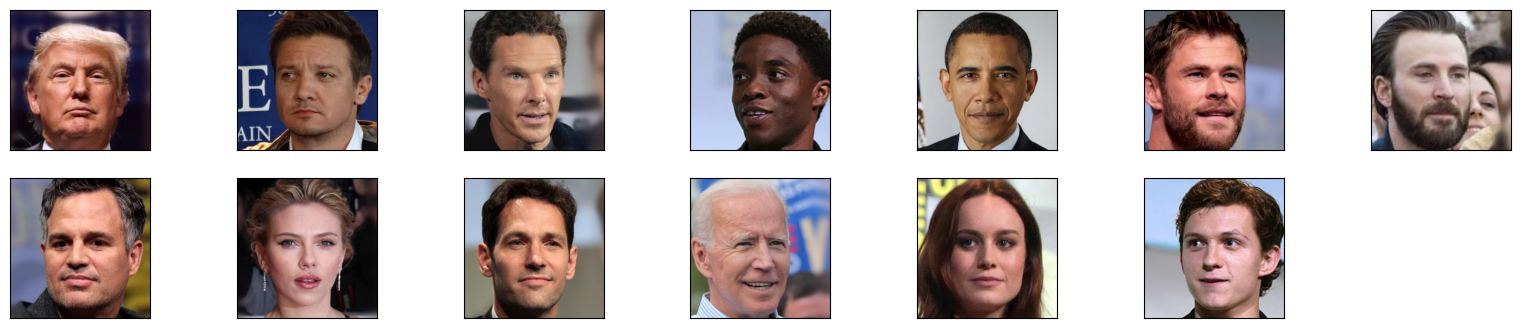

In [5]:
%matplotlib inline
images_list = vislize_folder_imgs(eval_image_paths) 

### Perform encode and decode for inversion

In [6]:
inputs = transform_to_input_batch(images_list, transform).to("cuda").float()

# batched_input shape: bs x 3 x w x h
with torch.no_grad():
    tic = time.time()
    recon_pSp, latent_pSp = pSp_net.forward(inputs, return_latents=True)
    latent_c, latent_s = cs_mlp_net(latent_pSp)
    recon_bg_c = pSp_net.forward(latent_c, input_code=True, randomize_noise=True, recon_modle=True)
    #recon_bg_cs = pSp_net.forward(latent_c+latent_s, input_code=True, randomize_noise=True, recon_modle=True)
    # latent_bg = latent_c 
	# latent_t = latent_c + latent_s
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.5166 seconds.


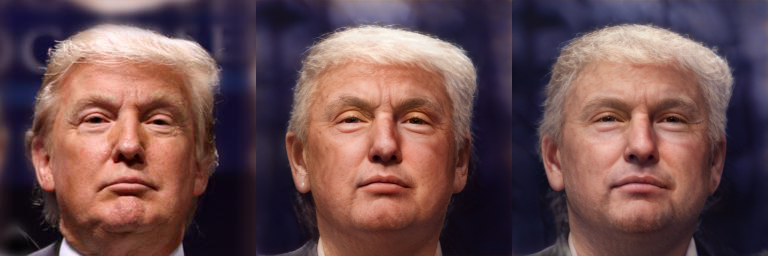

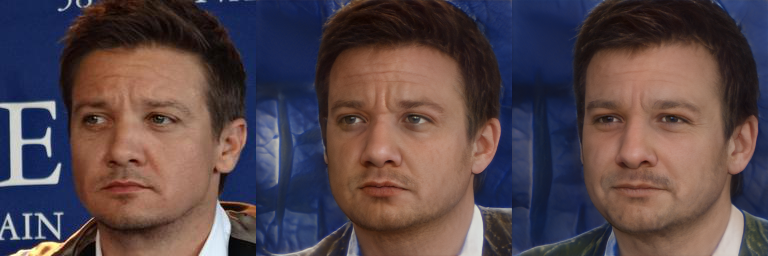

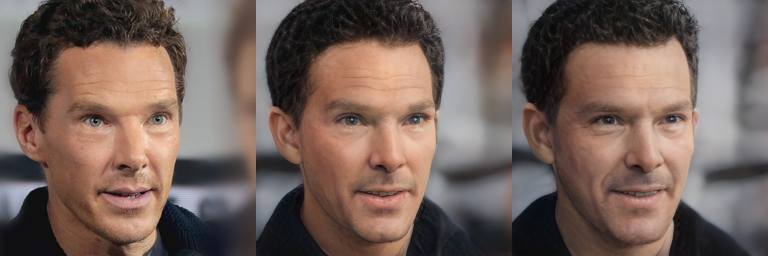

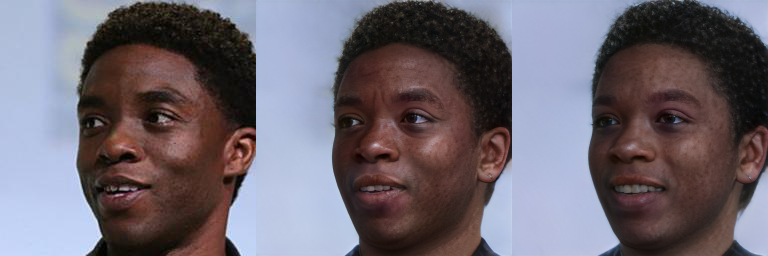

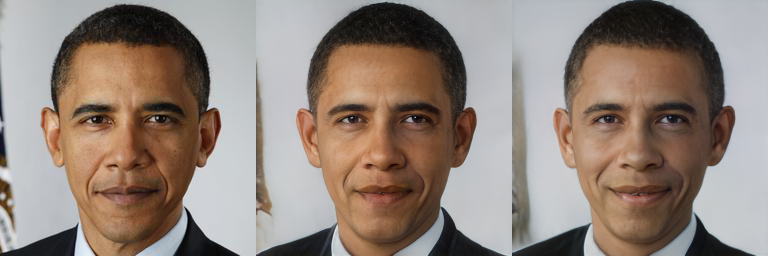

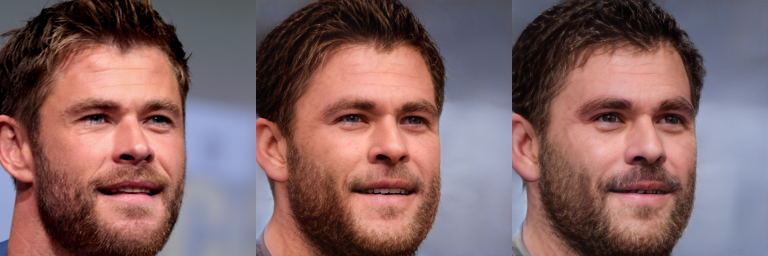

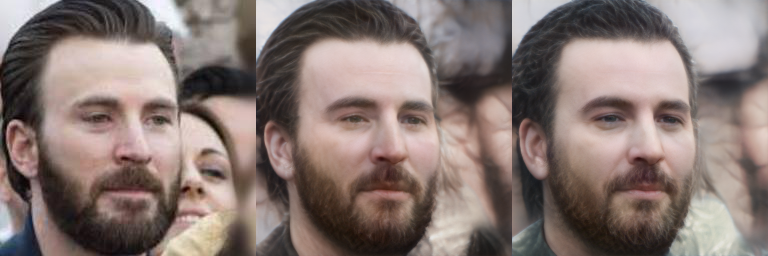

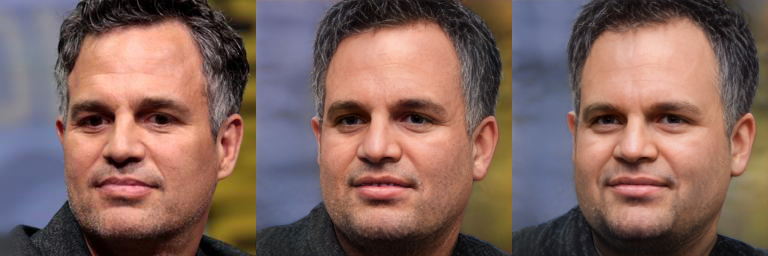

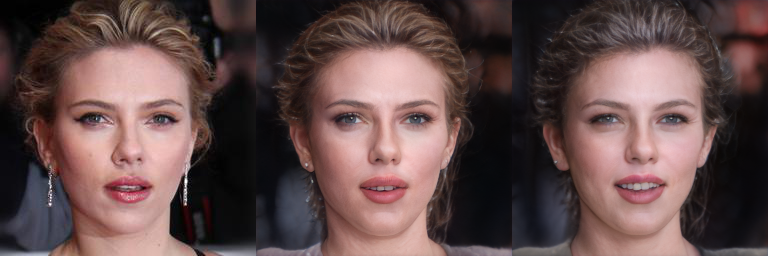

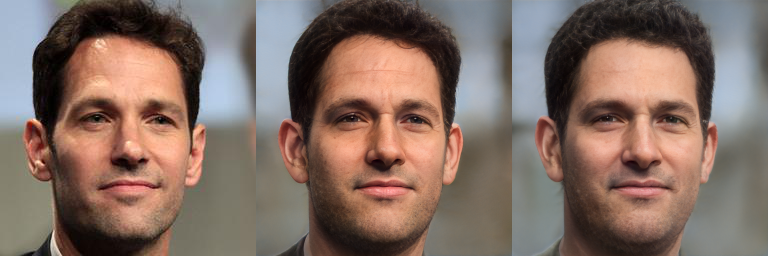

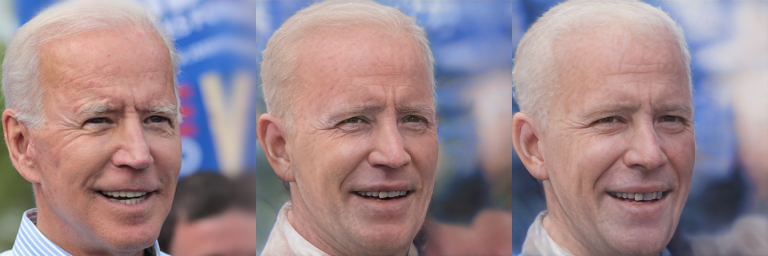

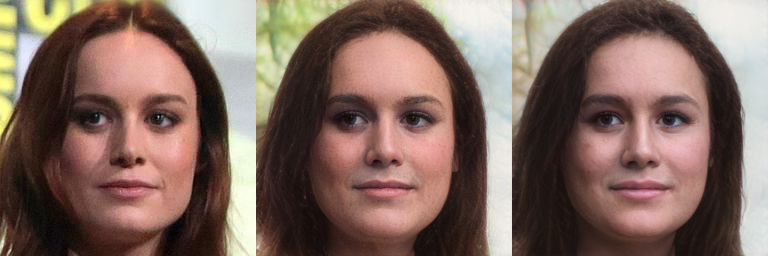

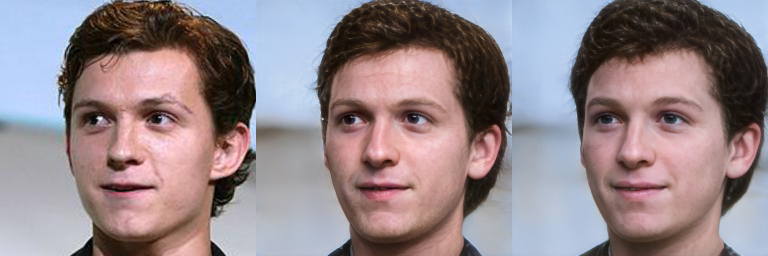

In [7]:
#visulize_images_paired3(images_list, recon_pSp, recon_bg_c)
visulize_images_paired3(inputs, recon_pSp, recon_bg_c)